In [11]:
import numpy as np
import math
import random
import carla
import time
import matplotlib.pyplot as plt

In [12]:
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.load_world('Town03')

In [13]:
blueprint_library = world.get_blueprint_library()
vehicle_bp = blueprint_library.filter("vehicle.audi.tt")[0]
starting_point = world.get_map().get_spawn_points()[0]
vehicle = world.try_spawn_actor(vehicle_bp,starting_point)
vehicle_pos = vehicle.get_transform()
lidar_bp = blueprint_library.find('sensor.lidar.ray_cast')
lidar_blueprint = blueprint_library.find("sensor.lidar.ray_cast")
lidar_blueprint.set_attribute("channels", str(64))
lidar_blueprint.set_attribute("points_per_second", str(500000))
lidar_blueprint.set_attribute("rotation_frequency", str(10.0))
lidar_blueprint.set_attribute("upper_fov", str(30.0))
lidar_blueprint.set_attribute("lower_fov", str(-25.0))
lidar_blueprint.set_attribute("range", str(100.0))
spectator_rotation = vehicle_pos.rotation
lidar_transform = carla.Transform(starting_point.location, spectator_rotation)
lidar_sensor = world.spawn_actor(lidar_blueprint, lidar_transform, attach_to = vehicle)
gps_bp = blueprint_library.find('sensor.other.gnss')
gps_bp.set_attribute("sensor_tick", "1.0")  
gps_location = carla.Transform(carla.Location(x=0, y=0, z=2))  
gps_sensor = world.spawn_actor(gps_bp, gps_location, attach_to=vehicle)

In [14]:
bounding_box = vehicle.bounding_box
vehicle_length = bounding_box.extent.x

In [15]:
def get_steering_angle(vehicle_location, target_location):
    dx = target_location[0] - vehicle_location.location.x
    dy = target_location[1] - vehicle_location.location.y
    angle_to_target = math.atan2(dy, dx)  # Angle to target in radians

    # Current vehicle yaw in radians
    current_yaw = math.radians(vehicle_location.rotation.yaw)

    # Steering angle is the difference between target angle and current yaw
    steering_angle = angle_to_target - current_yaw

    # Normalize steering angle to [-π, π]
    steering_angle = (steering_angle + math.pi) % (2 * math.pi) - math.pi

    # Scale the steering angle for smoother turns
    steering = steering_angle * 0.1  # Reduce the steering sensitivity

    return steering

In [16]:
def calculate_throttle(vehicle_location, target_location):
    dx = target_location[0] - vehicle_location.location.x
    dy = target_location[1] - vehicle_location.location.y
    distance_to_target = math.sqrt(dx**2 + dy**2)  # Euclidean distance

    # Always apply some throttle if the vehicle is far from the goal
    if distance_to_target > 1.0:
        return 0.5  # Fixed throttle value for testing
    else:
        return 0.0  # Stop if close to the goal

In [17]:
# Node class representing a state in the space
class Node:
    def __init__(self, x, y):  # Fix: Use __init__ instead of init
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0

# RRT* algorithm
class RRTStar:
    def __init__(self, vehicle_length, start, goal, map_size, carla_world, vehicle, lidar_sensor, gps_sensor, step_size=1.0, max_iter=900):  # Fix: Use __init__ instead of init
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.map_size = map_size
        self.step_size = step_size
        self.max_iter = max_iter
        self.node_list = [self.start]
        self.goal_region_radius = 4
        self.search_radius = 2
        self.path = None
        self.goal_reached = False
        self.carla_world = carla_world
        self.vehicle = vehicle
        self.lidar_sensor = lidar_sensor 
        self.gps_sensor = gps_sensor
        self.lidar_data = []
        self.vehicle_length = vehicle_length
        
    def process_lidar_data(self, point_cloud_data):
        points = np.frombuffer(point_cloud_data.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0]/4), 4))
        self.lidar_data = points[:, :3]  # Extract x, y, z coordinates
        # print("LIDAR Data:", self.lidar_data)  # Debug: Print LIDAR data
        return self.lidar_data
  
    def gps_callback(self, data):
        latitude = data.latitude
        longitude = data.longitude
        altitude = data.altitude
        print("Car Location:", self.vehicle.get_transform().location)  # Debug: Print car location
        print(f"GPS Data: Lat={latitude}, Lon={longitude}, Alt={altitude}")
          
    def get_nearest_node(self, node_list, rand_node):
        distances = [np.linalg.norm([node.x - rand_node.x, node.y - rand_node.y]) for node in node_list]
        nearest_node_idx = np.argmin(distances)
        return node_list[nearest_node_idx]
    
    def is_collision_free(self, node):
        if len(self.lidar_data) == 0:
            return True  # إذا لم تكن هناك بيانات ليدار، افترض أنه لا يوجد عائق
        
        safety_margin = 2.0  # مسافة أمان حول السيارة
        for point in self.lidar_data:
            obstacle_distance = math.sqrt((point[0] - node.x)**2 + (point[1] - node.y)**2)
            
            # إذا كانت المسافة إلى العائق أقل من المسافة الآمنة، فهناك عائق
            if obstacle_distance < self.vehicle_length + safety_margin:
                print(f"Obstacle detected at ({point[0]}, {point[1]}) with distance {obstacle_distance}")
                return False
        return True
    def get_random_node(self):
        if random.random() > 0.2:
            return Node(random.uniform(0, self.map_size[0]), random.uniform(0, self.map_size[1]))
        else:
            return Node(self.goal.x, self.goal.y)
    
    def choose_parent(self, neighbors, nearest_node, new_node):
        min_cost = nearest_node.cost + np.linalg.norm([new_node.x - nearest_node.x, new_node.y - nearest_node.y])
        best_node = nearest_node
        for neighbor in neighbors:
            cost = neighbor.cost + np.linalg.norm([new_node.x - neighbor.x, new_node.y - neighbor.y])
            if cost < min_cost and self.is_collision_free(neighbor):
                best_node = neighbor
                min_cost = cost
        new_node.cost = min_cost
        new_node.parent = best_node
        return new_node

    def find_neighbors(self, new_node):
        return [node for node in self.node_list
                if np.linalg.norm([node.x - new_node.x, node.y - new_node.y]) < self.search_radius]

    def rewire(self, new_node, neighbors):
        for neighbor in neighbors:
            cost = new_node.cost + np.linalg.norm([neighbor.x - new_node.x, neighbor.y - new_node.y])
            if cost < neighbor.cost and self.is_collision_free(neighbor):
                neighbor.parent = new_node
                neighbor.cost = cost

    def reached_goal(self, node):
        return np.linalg.norm([node.x - self.goal.x, node.y - self.goal.y]) < self.goal_region_radius

    def steer(self, from_node, to_node):
        theta = math.atan2(to_node.y - from_node.y, to_node.x - from_node.x)
        new_node = Node(from_node.x + self.step_size * math.cos(theta),
                        from_node.y + self.step_size * math.sin(theta))
        
        if not self.is_collision_free(new_node):
            return None  # Return None if collision is detected
        
        new_node.cost = from_node.cost + self.step_size
        new_node.parent = from_node
        return new_node
    
    def move_vehicle_along_path(self):
        if self.path:
            for point in self.path:
                target_location = point
                vehicle_pos = self.vehicle.get_transform()

                # Calculate steering and throttle
                steering_angle = get_steering_angle(vehicle_pos, target_location)
                steering = steering_angle * 0.1  # Smoother steering
                throttle = calculate_throttle(vehicle_pos, target_location)

                # Debug: Print control values
                print(f"Applying Control - Throttle: {throttle}, Steering: {steering}")

                # Check distance to goal
                distance_to_goal = np.linalg.norm([vehicle_pos.location.x - self.goal.x, 
                                                vehicle_pos.location.y - self.goal.y])
                if distance_to_goal < self.goal_region_radius:
                    print("Goal reached! Stopping the car.")
                    self.vehicle.apply_control(carla.VehicleControl(throttle=0, brake=10.0, steer=0))
                    return

                # Check for collisions
                if not self.is_collision_free(Node(target_location[0], target_location[1])):
                    print("Obstacle detected! Stopping and replanning...")
                    self.vehicle.apply_control(carla.VehicleControl(throttle=0, brake=10.0, steer=0))  # Stop the vehicle
                    time.sleep(1)  # Add a small delay before replanning
                    self.plan()  # Replan the path
                    return  # Exit the current path-following loop

                # Apply control to the vehicle
                self.vehicle.apply_control(carla.VehicleControl(throttle=throttle, brake=0.0, steer=steering))
                time.sleep(0.1)  # Add a small delay for smoother movement
        else:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0, brake=10.0, steer=0))
            print("No path to follow.")

    def generate_final_path(self, goal_node):
        path = []
        node = goal_node
        while node is not None:
            path.append([node.x, node.y])
            node = node.parent
        path = path[::-1]
        print("Generated Path:", path)  # Debug: Print the generated path
    
        X = [point[0] for point in path]
        Y = [point[1] for point in path]
        plt.scatter(X, Y, color='red', label='path')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Path Visualization")
        plt.legend()
        plt.show()
        return path        

    def plan(self):
        for i in range(self.max_iter):
            rand_node = self.get_random_node()
            nearest_node = self.get_nearest_node(self.node_list, rand_node)
            new_node = self.steer(nearest_node, rand_node)

            if new_node is not None:
                self.node_list.append(new_node)

                if self.reached_goal(new_node):
                    self.path = self.generate_final_path(new_node)
                    self.goal_reached = True
                    print("Goal reached! Stopping the vehicle.")
                    self.move_vehicle_along_path()
                    return

Generated Path: [[-6.446169853210449, -79.05502319335938], [-5.806483232917962, -78.28638737073673], [-5.462746007615286, -77.34732149448459], [-5.123527577868198, -76.40661385822351], [-5.049592778592203, -75.40935078086828], [-4.775889409261028, -74.44753662750145], [-4.134620418238247, -73.68022047287376], [-3.5753865580954556, -72.85121052741484], [-2.783361608359995, -72.24072180598213], [-2.3719176276788376, -71.32928675576669], [-1.8707232719811546, -70.46395201255064], [-1.5557220030586043, -69.51486076268202], [-0.9760508501431043, -68.7000102521725], [-0.7393028296224357, -67.72843916636378], [-0.4797919833617617, -66.76269897320981], [0.1593104768932671, -65.9935773668978], [0.6866604853221401, -65.14392922289343], [0.9753715649581145, -64.18651295371089], [1.2555628094450983, -63.22656875402382], [1.49078910243197, -62.25462812256136], [1.4828626747558737, -61.25465953718265], [1.6969010660407378, -60.277834288196836], [2.004344888921292, -59.32626805520378], [2.18784981380

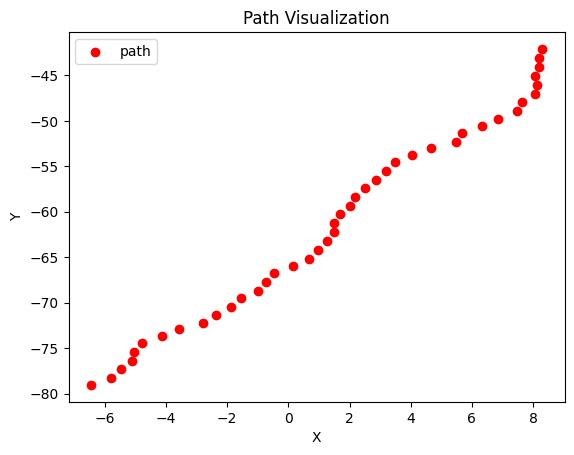

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.0, Steering: -0.01605776015606706
Car Location: Location(x=-6.446170, y=-79.055023, z=-0.011780)
GPS Data: Lat=0.0007101633561887866, Lon=-5.790692903169438e-05, Alt=1.9882197380065918
Applying Control - Throttle: 0.5, Steering: -0.007290701762793327
Car Location: Location(x=-6.446170, y=-79.055023, z=-0.012340)
GPS Data: Lat=0.0007101633561887866, Lon=-5.790692903169438e-05, Alt=1.9876595735549927
Applying Control - Throttle: 0.5, Steering: -0.005574718025131196
Car Location: Location(x=-6.446170, y=-79.055023, z=-0.011620)
GPS Data: Lat=0.0007101633561887866, Lon=-5.790692903169438e-05, Alt=1.988379955291748
Applying Control - Throttle: 0.5, Steering: -0.004981552375882364
Car Location: Location(x=-6.460269, y=-78.589333, z=-0.011858)
GPS Data: Lat=0.0007068399076501919, Lon=-5.80098701294687e-05, Alt=1.9881515502929688
Applying Control - Throttle: 0.5, Steering: -0.007451526155599063
Car Location: Location(x=-6.51223

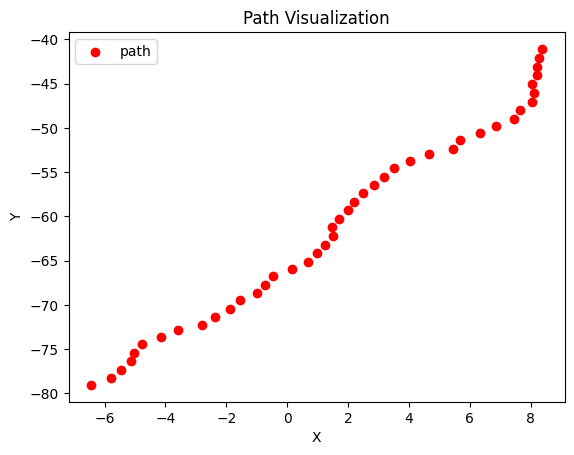

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.030616796545773185
Car Location: Location(x=-5.653386, y=-56.724094, z=-0.011522)
GPS Data: Lat=0.0005095550071700927, Lon=-5.0784490504883455e-05, Alt=1.9884779453277588
Applying Control - Throttle: 0.5, Steering: -0.0303329306171169
Car Location: Location(x=-5.653112, y=-56.722065, z=-0.012251)
GPS Data: Lat=0.000509556103736486, Lon=-5.0784631860418846e-05, Alt=1.9877477884292603
Applying Control - Throttle: 0.5, Steering: -0.030146526381029472
Car Location: Location(x=-5.561273, y=-56.064075, z=-0.011608)
GPS Data: Lat=0.0005042443568044064, Lon=-5.004624194554132e-05, Alt=1.988373041152954
Applying Control - Throttle: 0.5, Steering: -0.02992663927293253
Car Location: Location(x=-5.339062, y=-54.620884, z=-0.011805)
GPS Data: Lat=0.0004906777892870196, Lon=-4.796452467682248e-05, Alt=1.9881951808929443
Applying Control - Throttle: 0.5, Steering: -0.029796892732193676
Car Location: Location(x=-4.83384

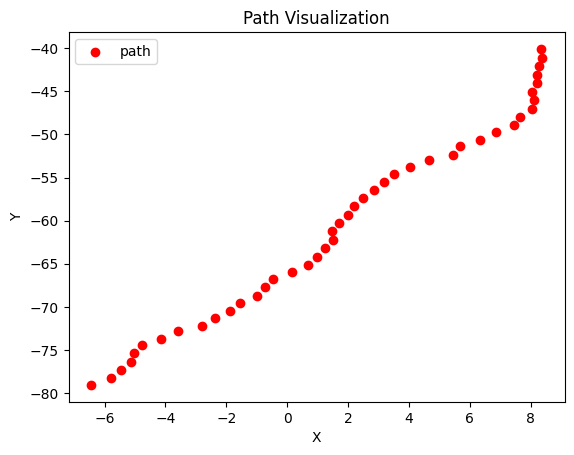

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.02978528982111685
Applying Control - Throttle: 0.5, Steering: -0.029624051953064036
Car Location: Location(x=-2.832192, y=-43.808853, z=-0.011534)
GPS Data: Lat=0.00039353504418215834, Lon=-2.5440203330449436e-05, Alt=1.9884660243988037
Car Location: Location(x=-2.681933, y=-43.298656, z=-0.011949)
GPS Data: Lat=0.0003901826734278302, Lon=-2.4461048529039374e-05, Alt=1.988023042678833
Applying Control - Throttle: 0.5, Steering: -0.029379607416463657
Car Location: Location(x=-2.138830, y=-41.568241, z=-0.011816)
GPS Data: Lat=0.0003758091971093336, Lon=-1.999202902508955e-05, Alt=1.988132119178772
Car Location: Location(x=-1.082524, y=-38.538105, z=-0.011836)
GPS Data: Lat=0.00034619773113320207, Lon=-9.72882899139706e-06, Alt=1.9881633520126343
Applying Control - Throttle: 0.5, Steering: -0.029051283352070596
Obstacle detected at (-3.055488109588623, -75.26307678222656) with distance 2.3631471148749315
O

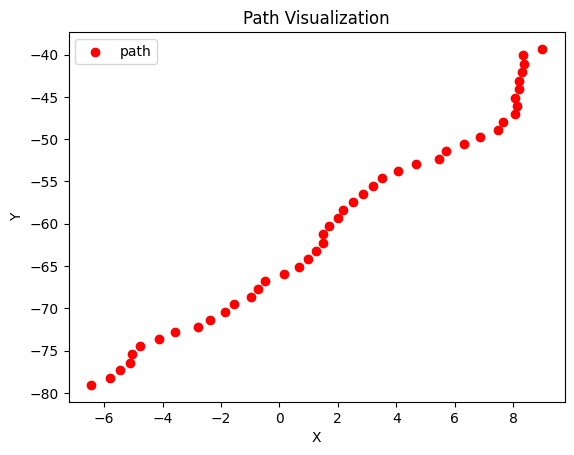

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.02920642377474633
Obstacle detected at (-9.28102970123291, -78.08074951171875) with distance 2.9976056386168457
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (6.289228439331055, -40.919734954833984) with distance 3.7533346834999737
Obstacle detected at (6.032861232757568, -35.72084045410156) with distance 3.7247592406734715
Obstacle detected at (10.1572265625, -41.5610237121582) with distance 3.1420358708471867
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (6.482148170471191, -36.26447296142578) with distance 3.867745890794726
Obstacle detected at (6.153656959533691, -40.57332992553711) with distance 3.7358247472381

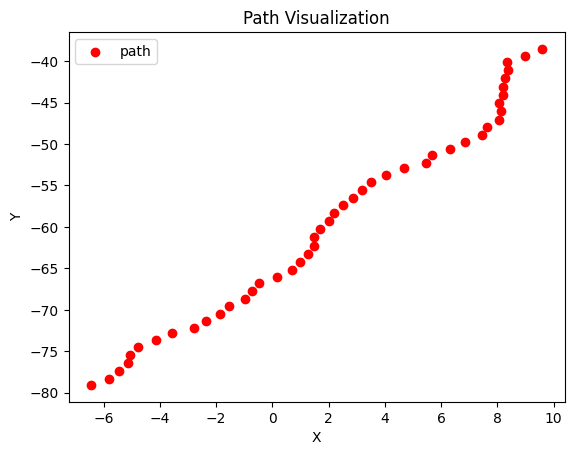

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.02920642377474633
Obstacle detected at (-5.85122537612915, -76.89823150634766) with distance 2.2373442542381348
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (6.811777114868164, -36.66123962402344) with distance 3.6249248144863113
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Generated Path: [[-6.446169853210449, -79.05502319335938], [-5.806483232917962, -78.28638737073673], [-5.462746007615286, -77.34732149448459], [-5.123527577868198, -76.40661385822351], [-5.049592778592203, -75.40935078

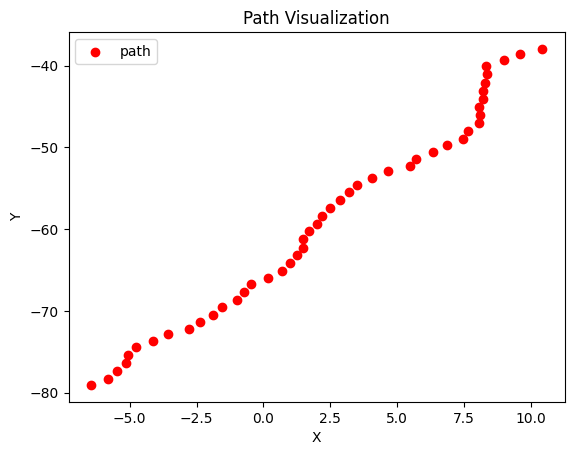

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.02920642377474633
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (-9.400346755981445, -78.07810974121094) with distance 3.1115142721598135
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Generated Path: [[-6.446169853210449, -79.05502319335938], [-5.806483232917962, -78.28638737073673], [-5.462746007615286, -77.34732149448459], [-5.123527577868198, -76.40661385822351], [-5.049592778592203, -75.40935078086828], [-4.775889409261028, -74.44753662750145], [-4.134620418238247, -73.68022047287376], 

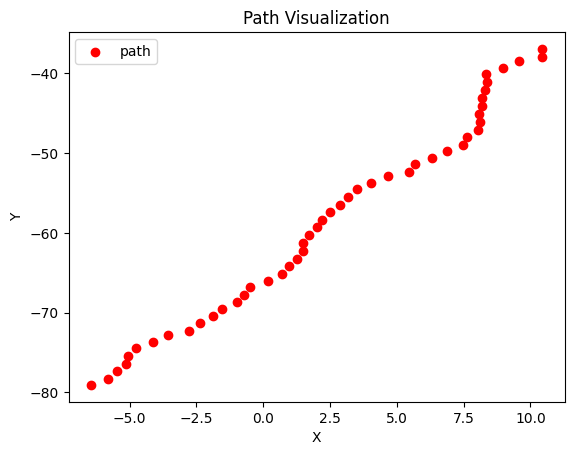

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.02920642377474633
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (-10.400464057922363, -78.50824737548828) with distance 3.9919176409874533
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Generated Path: [[-6.446169853210449, -79.05502319335938], [-5.806483232917962, -78.28638737073673], [-5.462746007615286, -77.34732149448459], [-5.123527577868198, -76.40661385822351], [-5.049592778592203, -75.40935078086828], [-4.775889409261028, -74.44753662750145], [-4.134620418238247, -73.68022047287376],

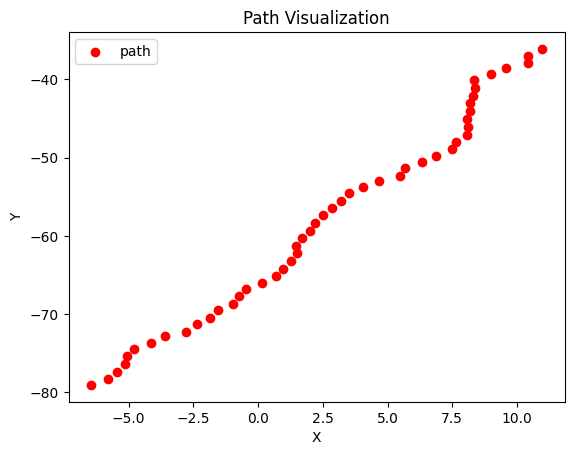

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.02920642377474633
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (-9.762924194335938, -78.19480895996094) with distance 3.426489148781305
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Car Location:O

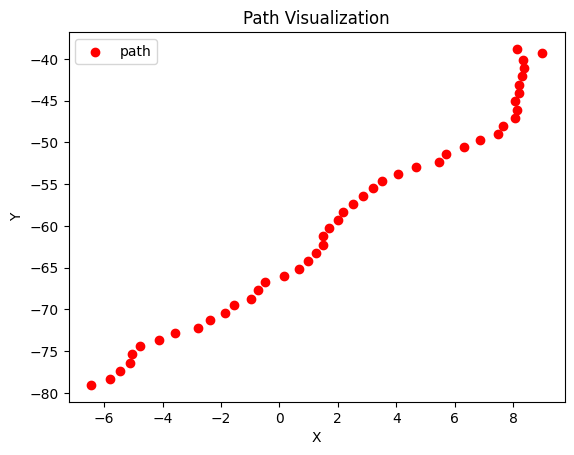

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.02920642377474633
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (-10.112553596496582, -78.34110260009766) with distance 3.7352446193677866
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (11.510316848754883, -29.747177124023438) with distance 4.030933014222534
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (10.206093788146973, -28.842802047729492) wit

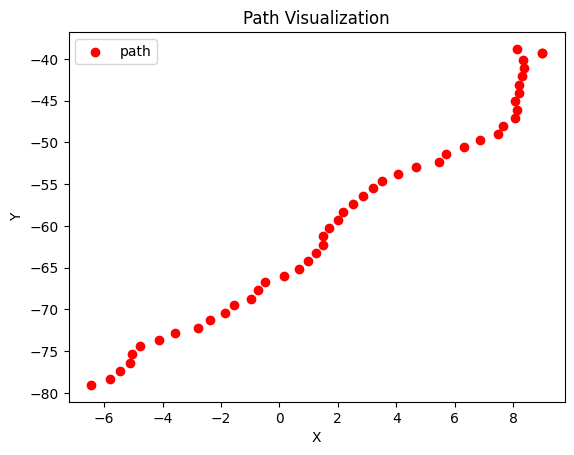

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.02920642377474633
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (-10.289057731628418, -78.48014831542969) with distance 3.8856490283305862
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Obstacle detected at (7.106889724731445, -37.01521301269531) with distance 2.975364308512098
Obstacle detected at (9.315258979797363, -28.20858383178711) with distance 3.270055502954391
Obstacle detected at (8.92726993560791, -27.927988052368164) with distance 4.082377454059919
Car Location: Location(x=0.4228

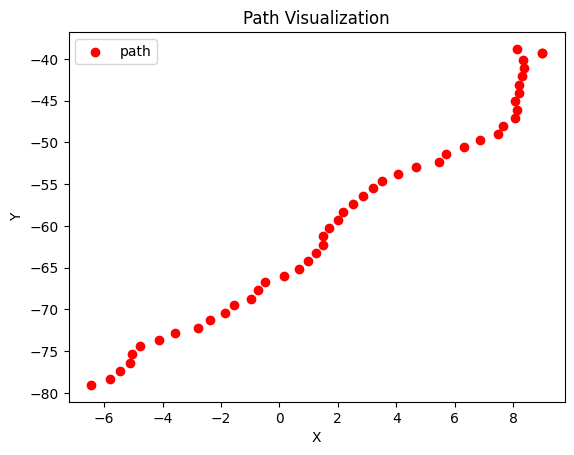

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.02920642377474633
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Car Location: Location(x=0.422883, y=-34.697079, z=0.069481)
GPS Data: Lat=0.0003126314628474347, Lon=3.4481573234720995e-06, Alt=2.0663464069366455
Applying Control - Throttle: 0.5, Steering: -0.029089795731350638
Car Location: Location(x=0.422981, y=-34.696918, z=0.068890)
GPS Data: Lat=0.000312637699622087, Lon=3.4375990287660212e-06, Alt=2.065685272216797
Obstacle detected at (-8.088505744934082, -77.47842407226562) with distance 2.420832798237969
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (8.70235824584961, -29.93634605407715) with distance 4.01973650689655
Obstacle 

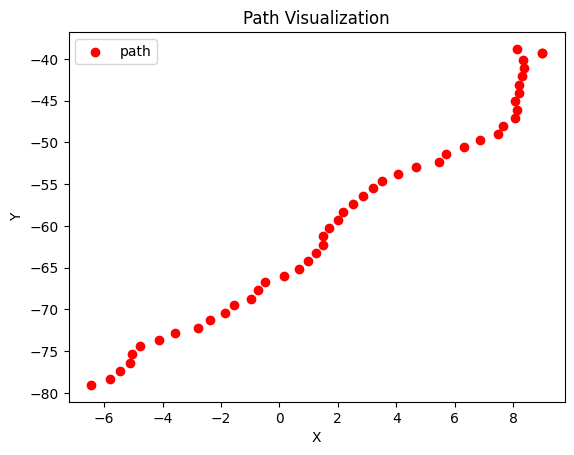

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.0292065107096406
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (-7.836245059967041, -79.26345825195312) with distance 1.4056152582020307
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (5.935844421386719, -40.04974365234375) with distance 3.134736251532033
Obstacle detected at (5.971728324890137, -38.63263702392578) with distance 3.0914280054185226
Obstacle detected at (11.632841110229492, -24.17951202392578) with distance 3.3674692830110464
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (12.10689449

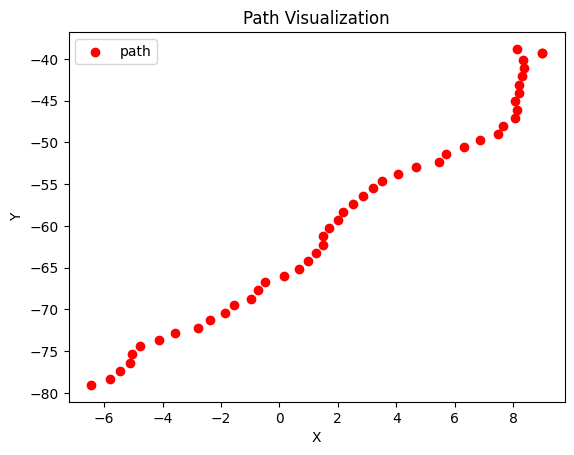

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.0292065107096406
Obstacle detected at (-10.018198013305664, -78.28068542480469) with distance 3.654994412625477
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (11.033720016479492, -23.919784545898438) with distance 4.005505399720076
Obstacle detected at (11.943857192993164, -24.311405181884766) with distance 3.44491496980529
Obstacle detected at (12.563612937927246, -24.567968368530273) with distance 2.3991730764445705
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (11.32719

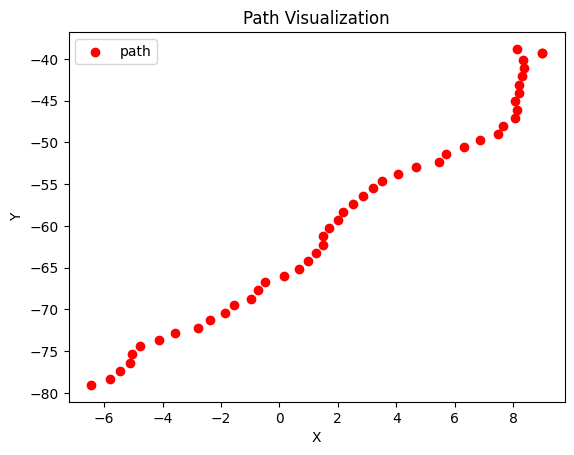

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.0292065107096406
Obstacle detected at (-8.438129425048828, -75.57904052734375) with distance 4.006289858494968
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (10.584569931030273, -23.71988296508789) with distance 3.885248105135146
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (11.877924919128418, -24.283594131469727) with distance 3.4201664207275546
Obstacle detected at (11.028325080871582, -23.917421340942383) with distance 4.0780267455597565Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615

Obstacle detected at (11.65406

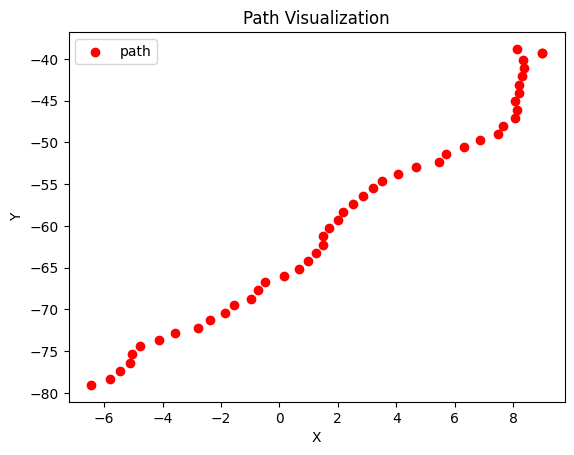

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.0292065107096406
Obstacle detected at (-9.708364486694336, -78.1517333984375) with distance 3.384944058672325
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (20.10743522644043, -22.2139835357666) with distance 4.055718883583642
Obstacle detected at (20.10743522644043, -22.2139835357666) with distance 4.044492820524629
Obstacle detected at (5.361952781677246, -37.834434509277344) with distance 3.9169725979348584
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (6.052832126617432, -38.73819351196289) with distance 2.9900076695113365
Obstacle detected at (20.049219131469727, -22.220468521118164) with distance 3.9446225965075

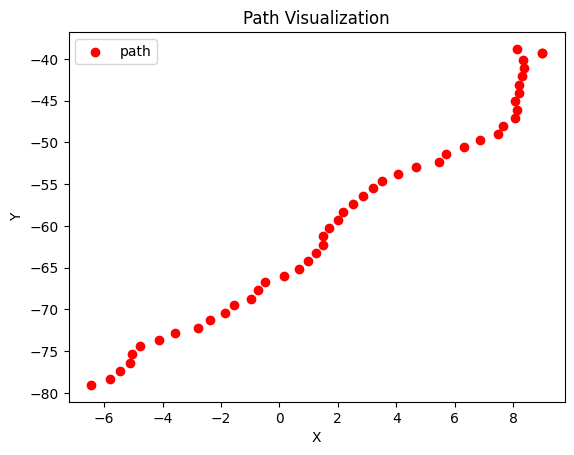

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.0292065107096406
Obstacle detected at (-8.269828796386719, -77.62255859375) with distance 2.318983995236025
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (12.78502368927002, -18.911922454833984) with distance 3.8510591167940356
Obstacle detected at (18.57168960571289, -17.628143310546875) with distance 4.059013400411194
Obstacle detected at (20.357934951782227, -20.189178466796875) with distance 3.8077924140973662
Obstacle detected at (9.8084077835083, -40.99101638793945) with distance 1.8602947901027773
Obstacle detected at (10.124701499938965, -41.01587677001953) with distance 2.0408567687634878Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255

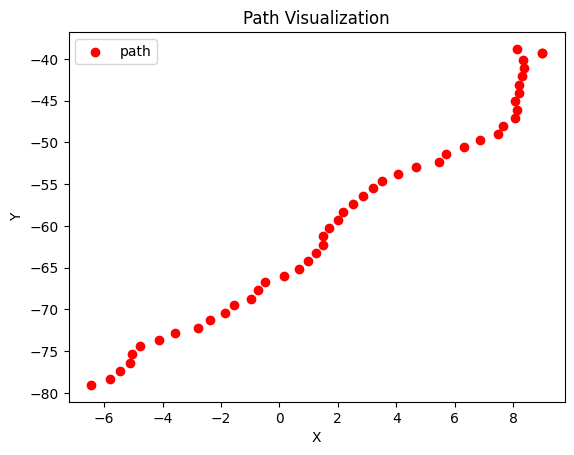

 Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.0292065107096406
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (-10.433080673217773, -78.62482452392578) with distance 4.010053463717648
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (20.30074691772461, -20.212675094604492) with distance 3.9710736131908484
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.00031252

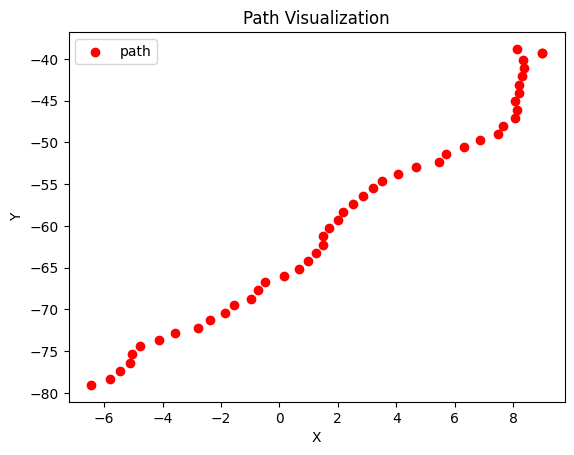

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.0292065107096406
Obstacle detected at (-8.160796165466309, -77.27828216552734) with distance 2.4691601954230817
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (19.845136642456055, -18.295244216918945) with distance 3.1039678032433167
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (9.83016586303711, -40.97845458984375) with distance 1.8588282602614323
Obstacle detected at (19.0963077545166, -17.328075408935547) with distance 2.3209905795860095
Obstacle detected at (19.0963077545166, -17.328075408935547) with distance 2.3013828610719713
Obstacle detected at (19.0963077545166, -17.328075408935547) with distance 2.335418752

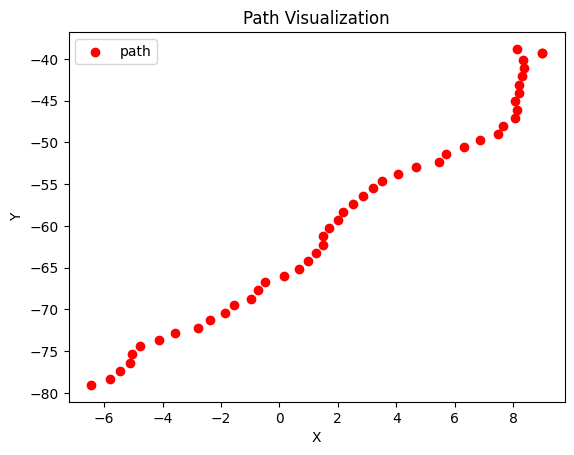

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.0292065107096406
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (-8.208549499511719, -77.54631042480469) with distance 2.319956084863879
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Obstacle detected at (6.067983150482178, -40.38725662231445) with distance 3.1052839131318466
Obstacle detected at (19.043060302734375, -17.38079071044922) with distance 2.574791328462994
Obstacle detected at (19.043060302734375, -17.38079071044922) with distance 2.241021743537334
Obstacle detected at (19.043060302

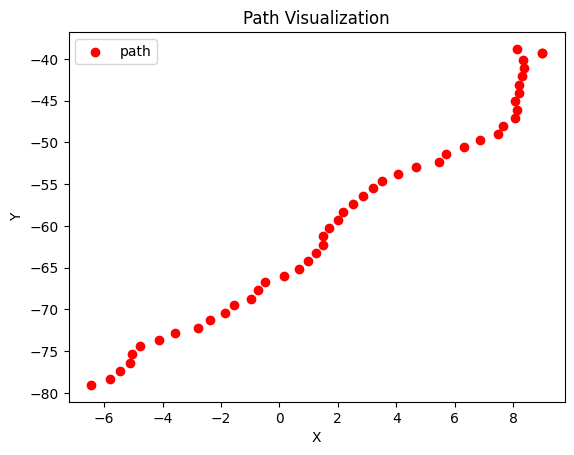

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.0292065107096406
Car Location: Location(x=0.428906, y=-34.682537, z=0.068992)
GPS Data: Lat=0.0003125249921396289, Lon=3.472544098234292e-06, Alt=2.0656468868255615
Applying Control - Throttle: 0.5, Steering: -0.029089712212806512
Car Location: Location(x=0.433970, y=-34.670006, z=0.068821)
GPS Data: Lat=0.0003124182472902248, Lon=3.514051223626816e-06, Alt=2.0654313564300537
Obstacle detected at (-7.80968713760376, -79.31441497802734) with distance 2.2515920245684127
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (19.8920841217041, -18.32976531982422) with distance 3.309009625039854
Obstacle detected at (6.069482326507568, -40.251991271972656) with distance 3.0601266722318203
Obstacle detected at (19.920331954956055, -18.399276733398438) 

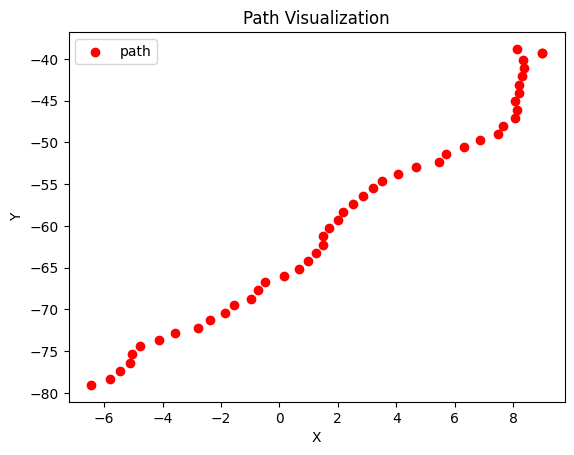

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029192656770422678
Obstacle detected at (-8.05117130279541, -77.65618896484375) with distance 2.129029556402806
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (19.45130729675293, -17.18341827392578) with distance 3.1460232840823723Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797

Obstacle detected at (20.362211227416992, -20.13980484008789) with distance 3.750823631309875
Obstacle detected at (10.158334732055664, -40.95966720581055) with distance 2.0138791019855597
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (6.08971166

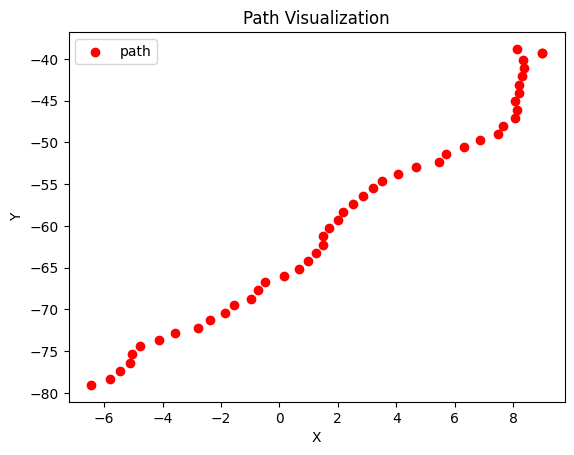

Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029192656770422678
Obstacle detected at (-8.692744255065918, -77.83929443359375) with distance 2.5544261508983817
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (18.833969116210938, -17.59612274169922) with distance 2.2037181568272137
Obstacle detected at (19.109760284423828, -17.286483764648438) with distance 2.431604558837818
Obstacle detected at (19.109760284423828, -17.286483764648438) with distance 2.698558966330897
Obstacle detected at (19.109760284423828, -17.286483764648438) with distance 2.6152962916444347
Obstacle detected at (19.109760284423828, -17.286483764648438) with distance 2.6

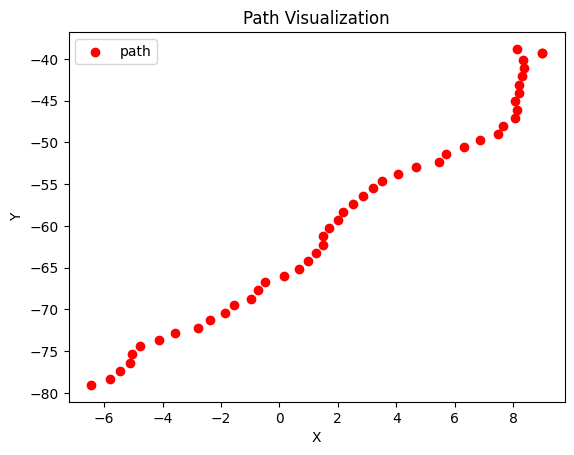

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029192656770422678
Obstacle detected at (-9.494999885559082, -78.21218872070312) with distance 3.1631842365642733
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (6.12710428237915, -40.39781188964844) with distance 3.053512063712858
Obstacle detected at (19.094829559326172, -17.30135726928711) with distance 2.3748880724535253
Obstacle detected at (20.231996536254883, -20.193750381469727) with distance 4.064711812158736
Obstacle detected at (19.094829559326172, -17.30135726928711) with distance 2.5969662074418767
Obstacle detected at (20.231996536254883, -20.193750381469727) with distance 3.7676231102163973
Obstacle detected at (20.231996536254883, -20.193750381469727) with distance 3.563528402771607
Car Location: Location(x=0.541832, y=-34.

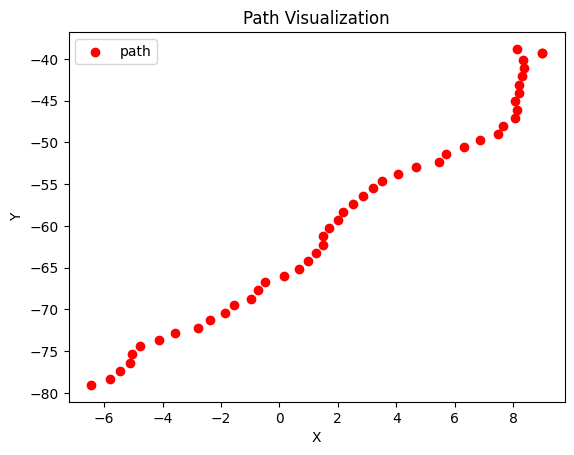

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029192656770422678
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (-9.947558403015137, -78.38511657714844) with distance 3.5648978458220317
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (20.725893020629883, -19.98921775817871) with distance 4.024263346572703
Generated Path: [[-6.446169853210449, -79.05502319335938], [-5.806483232917962, -78.28638737073673], [-5.462746007615286, -77.34732149448459], [-5.123527577868198, -76.40661385822351], [-5.049592778592203, -75.40935078086828], [-4.775889409261028, -74.44753662750145], [-4.134620418238247, -73.68022047287376], [-3.5753865580954556, -72.85121052741484], [-2.783361608

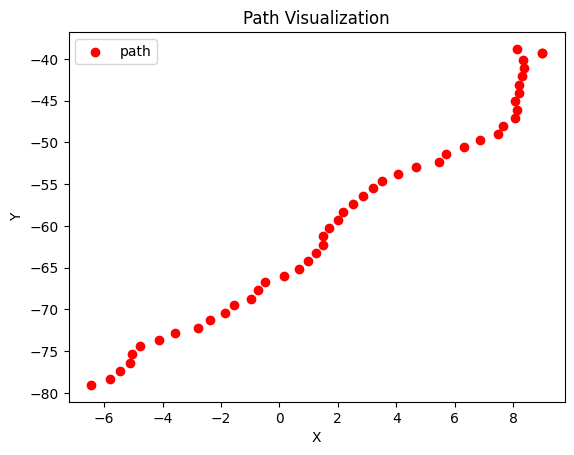

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029192656770422678
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (-9.8608980178833, -78.32597351074219) with distance 3.491687540192313
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (19.45088768005371, -18.313602447509766) with distance 2.3820299068717254
Obstacle detected at (20.375751495361328, -20.13418960571289) with distance 3.7931311158507843
Obstacle detected at (19.039287567138672, -17.3565616607666) with distance 2.1986354835086375
Obstacle detected at (19.039287567138672, -17.3565616607666) with distance 2.5488107148744428
Obstacle detected at (19.04473114013672, -17.351152420043945) with distance 2.52389207

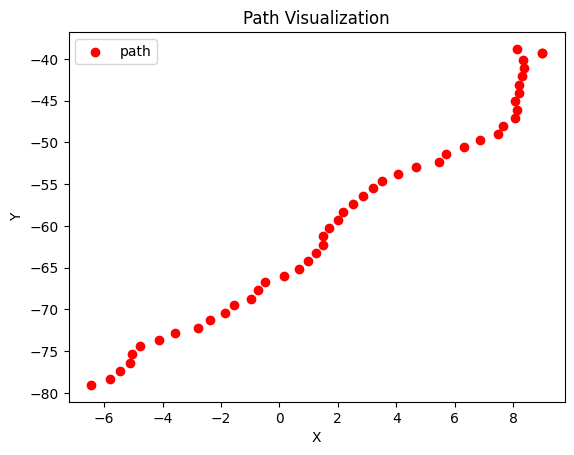

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029192656770422678
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (-8.172743797302246, -76.0576171875) with distance 3.459118435147683
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (19.135766983032227, -17.26056671142578) with distance 2.815705711030259
Obstacle detected at (19.135766983032227, -17.26056671142578) with distance 2.476044635980713
Obstacle detected at (19.069931030273438, -17.32610321044922) with distance 2.6159198285613634
Obstacle detected at (13.0772066116333, -15.566757202148438) with distance 4.083384123921581
Obstacle detected at (19.86808967590332, -18.270742416381836) with distance 3.610531838093

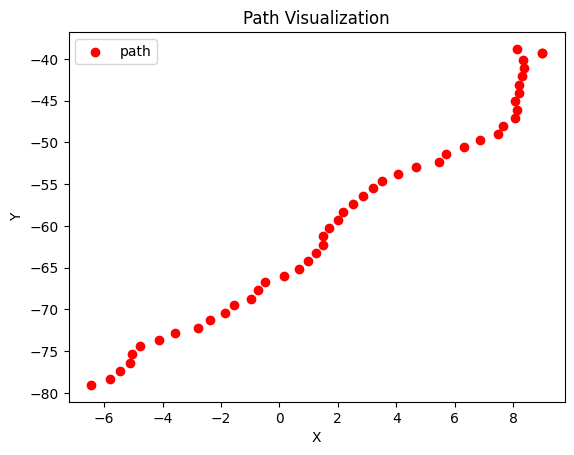

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029192656770422678
Obstacle detected at (-9.481328010559082, -78.21627044677734) with distance 3.1489190542182643
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Obstacle detected at (20.540199279785156, -18.604257583618164) with distance 3.900244852517223
Obstacle detected at (20.238750457763672, -20.190956115722656) with distance 3.831318281042577
Obstacle detected at (19.09810447692871, -17.298086166381836) with distance 2.4246057851097564
Obstacle detected at (19.09810447692871, -17.298086166381836) with distance 2.6878640379651495
Obstacle detected at (20.238750457763672, -20.190956115722656) with distance 3.925908745047729
Obstacle detected at (20.238750457763672, -20.190956115722656) with distance 3.9374536101500732
Obstacle detected at (20.2387504577636

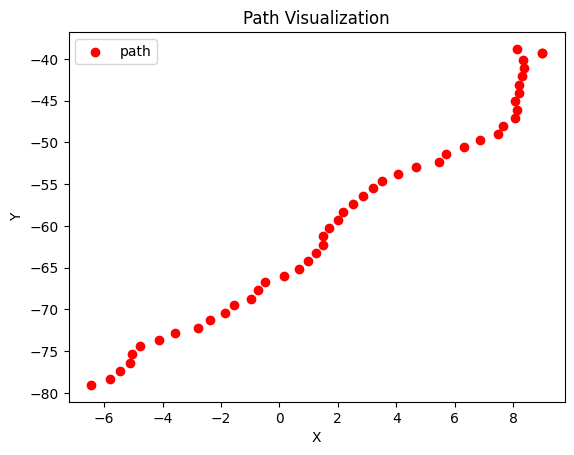

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029192656770422678
Car Location: Location(x=0.541832, y=-34.408909, z=0.069023)
GPS Data: Lat=0.00031006533730248975, Lon=4.485837867754543e-06, Alt=2.065685272216797
Applying Control - Throttle: 0.5, Steering: -0.029076912673367025
Obstacle detected at (-9.4742431640625, -78.21818542480469) with distance 3.668393983467193
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.544570, y=-34.402367, z=0.068706)
GPS Data: Lat=0.00031000889788401764, Lon=4.508479651267325e-06, Alt=2.0653493404388428
Obstacle detected at (19.06094741821289, -17.337549209594727) with distance 2.793488492219168
Obstacle detected at (10.063202857971191, -40.78795623779297) with distance 1.8190362779565608
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.00030986401273480624, Lon=4.563129628825547e-06, Alt=2.0656728744506836
Obstacle detected at (13.440727233886719, -15.4381732940673

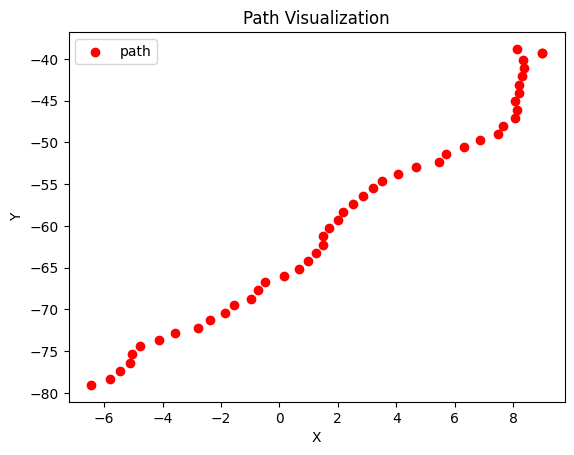

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029188025924832436
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.00030986401273480624, Lon=4.563129628825547e-06, Alt=2.0656728744506836
Obstacle detected at (-8.012953758239746, -77.61251068115234) with distance 2.1297075275569397
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.00030986401273480624, Lon=4.563129628825547e-06, Alt=2.0656728744506836
Obstacle detected at (20.477392196655273, -20.103153228759766) with distance 3.6431111924913884
Obstacle detected at (20.477392196655273, -20.103153228759766) with distance 3.6715536405913274
Obstacle detected at (20.5413761138916, -20.292762756347656) with distance 3.8040926350416293
Obstacle detected at (13.448226928710938, -15.612177848815918) with distance 3.682356274056521
Obstacle detected at (13.448226928710938, -15.612177848815918) with distance 3

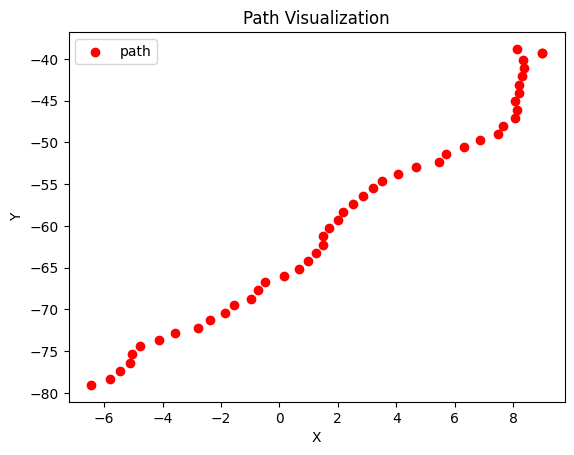

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029188025924832436
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.00030986401273480624, Lon=4.563129628825547e-06, Alt=2.0656728744506836
Obstacle detected at (-9.447416305541992, -78.18047332763672) with distance 3.1260706542348315
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.00030986401273480624, Lon=4.563129628825547e-06, Alt=2.0656728744506836
Obstacle detected at (10.032699584960938, -40.80584716796875) with distance 1.8157091223947968
Obstacle detected at (20.518798828125, -20.085975646972656) with distance 3.7368532697841124
Obstacle detected at (19.858104705810547, -18.225908279418945) with distance 2.9770786136198435
Obstacle detected at (19.858104705810547, -18.225908279418945) with distance 3.0233865678994887
Obstacle detected at (6.127138614654541, -40.290008544921875) with distance 3.0

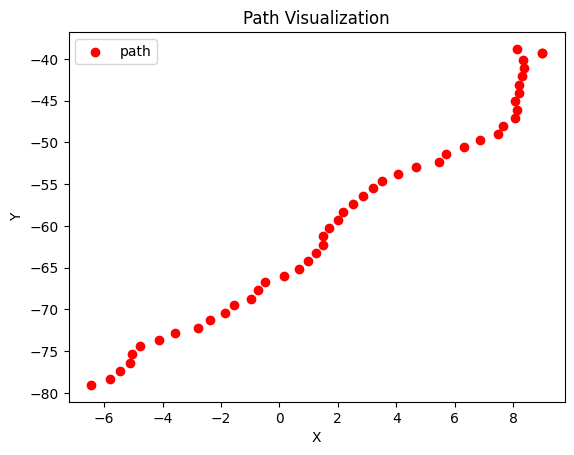

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029188025924832436
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.00030986401273480624, Lon=4.563129628825547e-06, Alt=2.0656728744506836
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.00030986401273480624, Lon=4.563129628825547e-06, Alt=2.0656728744506836
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.00030986401273480624, Lon=4.563129628825547e-06, Alt=2.0656728744506836
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.00030986401273480624, Lon=4.563129628825547e-06, Alt=2.0656728744506836
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.00030986401273480624, Lon=4.563129628825547e-06, Alt=2.0656728744506836
Applying Control - Throttle: 0.5, Steering: -0.029072366707031446
Car Location: Location(x=0.550879, y=-34.386395, z=0.069026)
GPS Data: Lat=0.0003098640

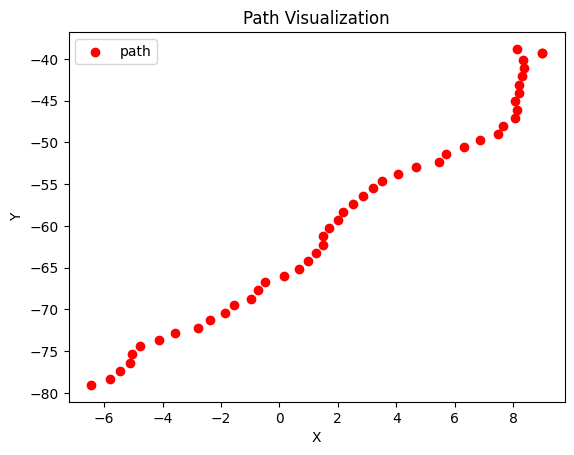

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029134551496986662
Obstacle detected at (-9.371186256408691, -78.55542755126953) with distance 2.9673754000082204
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.895973, y=-33.556759, z=0.068383)
GPS Data: Lat=0.00030240664295888564, Lon=7.644341903797214e-06, Alt=2.065011501312256
Obstacle detected at (19.09456443786621, -17.21944236755371) with distance 2.4079144877607908
Car Location: Location(x=0.895973, y=-33.556759, z=0.068383)
GPS Data: Lat=0.00030240664295888564, Lon=7.644341903797214e-06, Alt=2.065011501312256
Obstacle detected at (9.356679916381836, -40.852500915527344) with distance 1.5741668747043422
Obstacle detected at (20.396015167236328, -20.046483993530273) with distance 4.053259466419849
Obstacle detected at (19.861122131347656, -18.009111404418945) with distance 3.2665210116362275
Car Location: Location(x=0.895973, y=-33.556759, z=0.068383)
GPS Data: Lat=0.0003

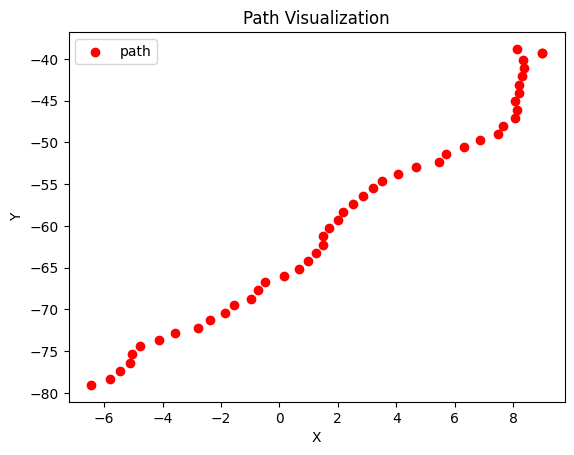

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029134551496986662
Car Location: Location(x=0.895973, y=-33.556759, z=0.068383)
GPS Data: Lat=0.00030240664295888564, Lon=7.644341903797214e-06, Alt=2.065011501312256
Obstacle detected at (-8.699370384216309, -78.38148498535156) with distance 2.351715618558388
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.895973, y=-33.556759, z=0.068383)
GPS Data: Lat=0.00030240664295888564, Lon=7.644341903797214e-06, Alt=2.065011501312256
Obstacle detected at (4.997792720794678, -39.007774353027344) with distance 3.999762909325058
Car Location: Location(x=0.895973, y=-33.556759, z=0.068383)
GPS Data: Lat=0.00030240664295888564, Lon=7.644341903797214e-06, Alt=2.065011501312256
Obstacle detected at (9.5631103515625, -40.734619140625) with distance 1.5255374186330488
Obstacle detected at (19.862211227416992, -18.01171875) with distance 3.1571939649242786
Obstacle detected at (19.862211227416992,

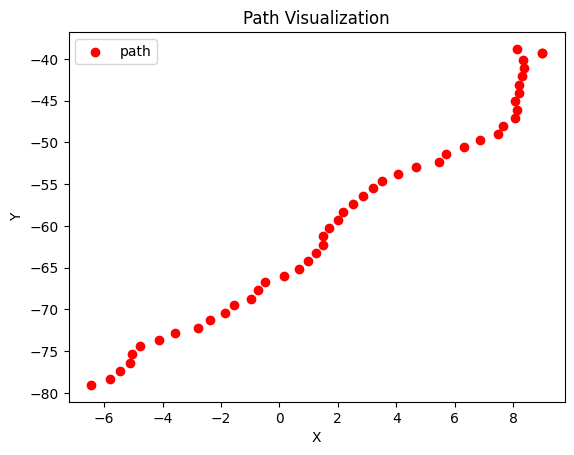

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029134551496986662
Car Location: Location(x=0.895973, y=-33.556759, z=0.068383)
GPS Data: Lat=0.00030240664295888564, Lon=7.644341903797214e-06, Alt=2.065011501312256
Obstacle detected at (-9.10305118560791, -80.44754028320312) with distance 2.999687026999486
Obstacle detected! Stopping and replanning...
Car Location: Location(x=0.895973, y=-33.556759, z=0.068383)
GPS Data: Lat=0.00030240664295888564, Lon=7.644341903797214e-06, Alt=2.065011501312256
Obstacle detected at (20.65652847290039, -19.935428619384766) with distance 3.717272685894058
Obstacle detected at (19.835872650146484, -17.948486328125) with distance 3.2999840029313563
Obstacle detected at (20.38971710205078, -20.049179077148438) with distance 4.003616266315358
Obstacle detected at (20.38971710205078, -20.049179077148438) with distance 3.7933841934484405
Obstacle detected at (19.186996459960938, -17.12593650817871) with distance 2.509035505

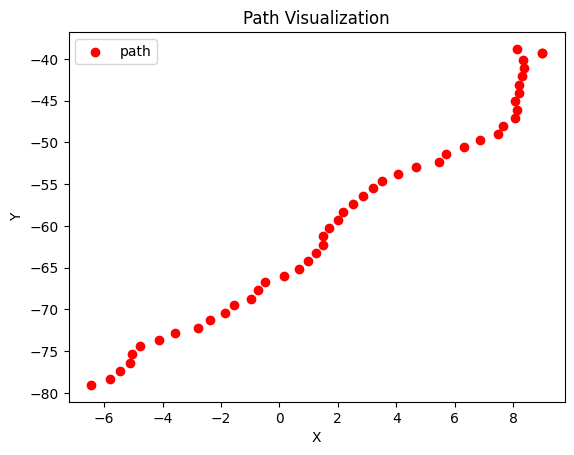

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029134551496986662
Car Location: Location(x=0.895973, y=-33.556759, z=0.068383)
GPS Data: Lat=0.00030240664295888564, Lon=7.644341903797214e-06, Alt=2.065011501312256
Applying Control - Throttle: 0.5, Steering: -0.02902921046162756
Car Location: Location(x=0.894704, y=-33.554897, z=0.063322)
GPS Data: Lat=0.00030243111034167214, Lon=7.542563776564082e-06, Alt=2.059447765350342
Obstacle detected at (-9.325102806091309, -78.61837768554688) with distance 3.53424691693242
Obstacle detected! Stopping and replanning...
Car Location: Location(x=1.189724, y=-32.827198, z=0.119600)
GPS Data: Lat=0.00029528037072168445, Lon=1.0829806563309017e-05, Alt=2.1190688610076904
Obstacle detected at (18.04792022705078, -18.027772903442383) with distance 0.8543814224191636
Obstacle detected at (18.04792022705078, -18.027772903442383) with distance 0.9134670639466358
Obstacle detected at (11.011542320251465, -42.173320770263

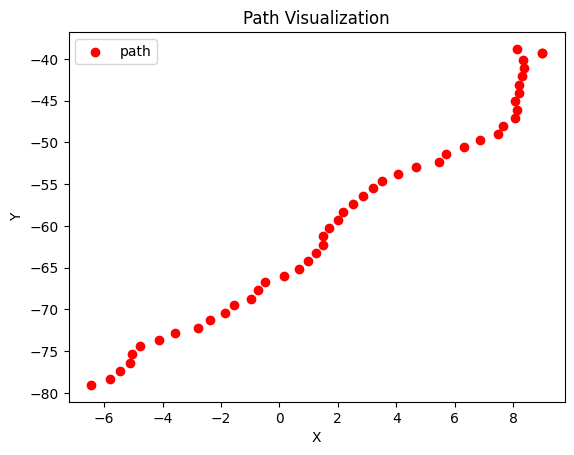

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029129370828254494
Obstacle detected at (-10.170917510986328, -78.92341613769531) with distance 3.7270719782702693
Obstacle detected! Stopping and replanning...
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Obstacle detected at (18.167139053344727, -17.91634750366211) with distance 1.3889537132818313
Obstacle detected at (17.756406784057617, -16.97452163696289) with distance 1.4559061605302308
Obstacle detected at (17.756406784057617, -16.97452163696289) with distance 1.2796270486363255
Obstacle detected at (11.23013687133789, -41.98801803588867) with distance 3.484736293973849
Obstacle detected at (19.284095764160156, -19.018827438354492) with distance 2.427682596167699
Obstacle detected at (18.016571044921875, -18.05697250366211) with distance 1.492219657258968
Obstacle detected at (18.01657104492187

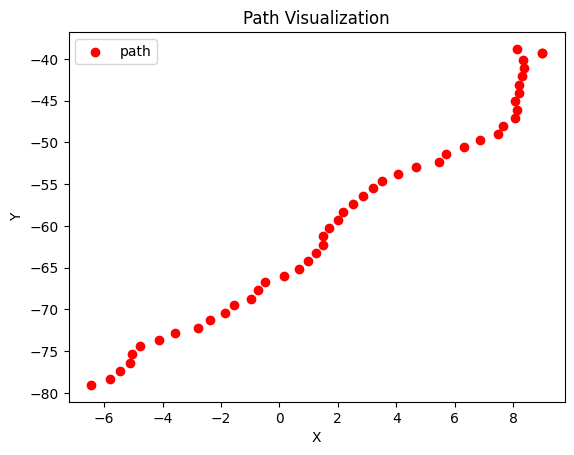

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029129370828254494
Obstacle detected at (-8.539530754089355, -78.0794906616211) with distance 2.3095072162277925
Obstacle detected! Stopping and replanning...
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Obstacle detected at (18.115503311157227, -17.96466827392578) with distance 1.6130170436007136
Obstacle detected at (11.29872989654541, -41.966758728027344) with distance 3.5132900194936636
Obstacle detected at (18.040624618530273, -18.03455924987793) with distance 1.8102739531966978
Obstacle detected at (17.947954177856445, -18.120771408081055) with distance 1.068407467280634
Obstacle detected at (17.947954177856445, -18.120771408081055) with distance 1

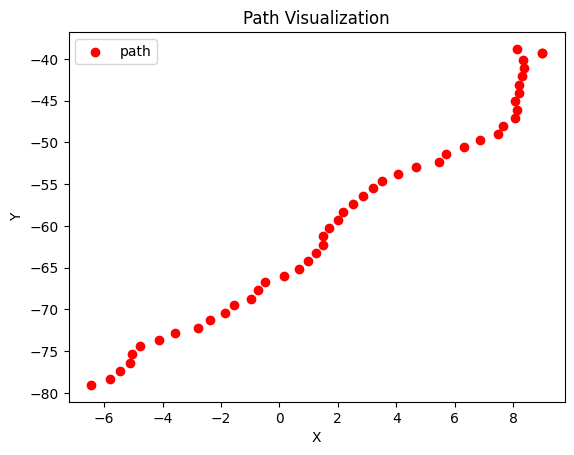

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029129370828254494
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Obstacle detected at (-9.6550874710083, -78.5331039428711) with distance 3.251084739259143
Obstacle detected! Stopping and replanning...
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Obstacle detected at (17.9964542388916, -18.075702667236328) with distance 1.332972959230629
Obstacle detected at (17.9964542388916, -18.075702667236328) with distance 1.634733549294283
Obstacle detected at (17.9964542388916, -18.075702667236328) with distance 1.345853200291829
Obstacle detected at (17.9964542388916, -18.075702667236328) with distance 1.3888427081230335
Obstacle detected at (17.9964542388916, -18.075702667236328) with distance 1.32550146490

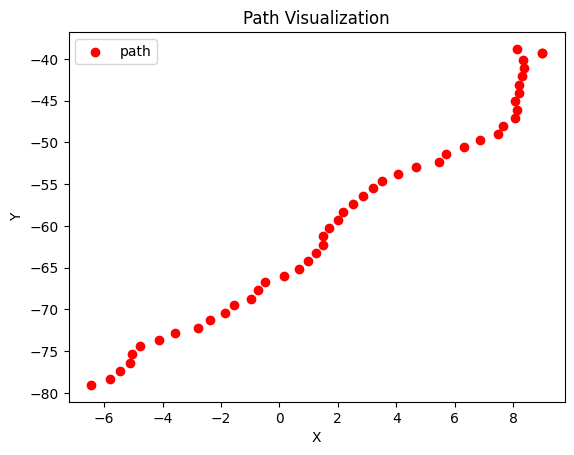

Goal reached! Stopping the vehicle.Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033

Applying Control - Throttle: 0.5, Steering: -0.029129370828254494
Obstacle detected at (-10.183573722839355, -78.73966979980469) with distance 3.7506846638372013
Obstacle detected! Stopping and replanning...
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Obstacle detected at (11.390332221984863, -41.93825912475586) with distance 3.5532477226959323
Obstacle detected at (11.96737289428711, -41.76837921142578) with distance 3.8567576707460964
Obstacle detected at (18.037710189819336, -18.03728485107422) with distance 0.7210811755554396
Obstacle detected at (18.037710189819336, -18.03728485107422) with distance 0.9147702309531177
Obstacle detected at (18.037710189819336, -18.03728485107422) with distance 1

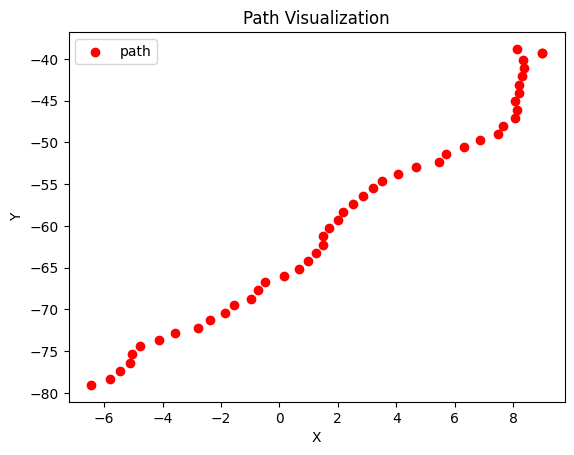

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029129370828254494
Obstacle detected at (-10.294218063354492, -78.88330078125) with distance 3.8518779334778297
Obstacle detected! Stopping and replanning...
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Obstacle detected at (17.64607810974121, -17.055116653442383) with distance 0.6261814219594599
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Generated Path: [[-6.446169853210449, -79.05502319335938], [-5.806483232917962, -78.28638737073673], [-5.462746007615286, -77.34732149448459], [-5.123527577868198, -76.40661385822351], [-5.049592778592203, -75.40935078086828], [-4.775889409261028, -74.44753662750145], [-4.134620418238247, -73.68022047287376], [-3.5753865580954556, -72.85121052741484], [-2.783361

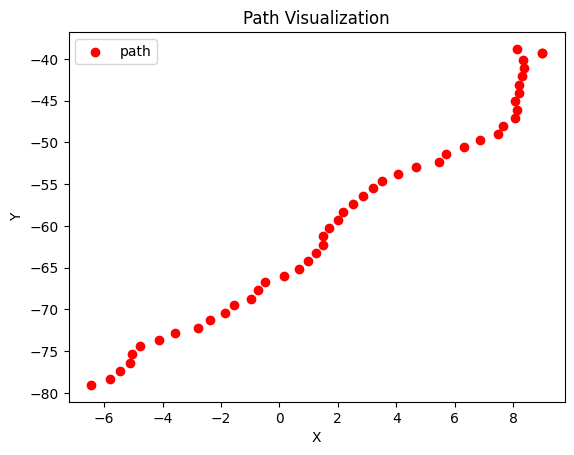

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029129370828254494
Obstacle detected at (-9.773163795471191, -78.59989929199219) with distance 3.357979520103624Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033

Obstacle detected! Stopping and replanning...
Obstacle detected at (17.553104400634766, -17.123153686523438) with distance 0.28447393156674844
Obstacle detected at (17.553104400634766, -17.123153686523438) with distance 0.2787647075121597
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Obstacle detected at (11.018837928771973, -42.1428108215332) with distance 3.4768332503687374
Obstacle detected at (19.968149185180664, -19.610233306884766) with distance 3.2705628148371346
Obstacle detected at (18.056243896484375, -18.020009994506836) with distanc

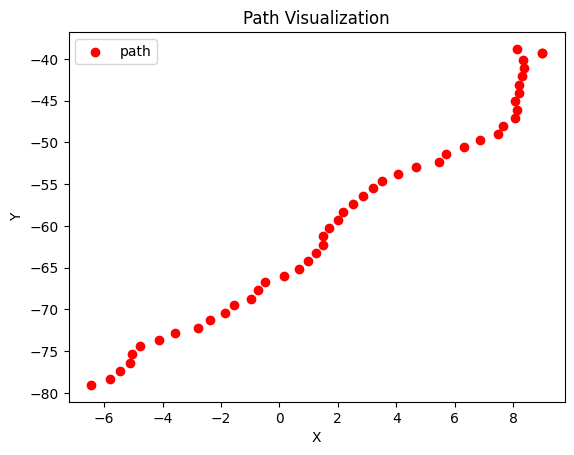

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.029129370828254494
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Car Location: Location(x=1.283255, y=-32.601746, z=0.140354)
GPS Data: Lat=0.00029287410542622183, Lon=1.1539991765374667e-05, Alt=2.1403534412384033
Applying Control - Throttle: 0.5, Steering: -0.0290201671748653
Car Location: Location(x=1.285247, y=-32.597206, z=0.140399)
GPS Data: Lat=0.0002928281520269138, Lon=1.154830604095639e-05, Alt=2.140399217605591
Car Location: Location(x=1.697130, y=-31.660463, z=0.095071)
GPS Data: Lat=0.0002844444666010304, Lon=1.675203057798612e-05, Alt=2.088024139404297
Applying Control - Throttle: 0.5, Steering: -0.028856512319151834
Car Location: Location(x

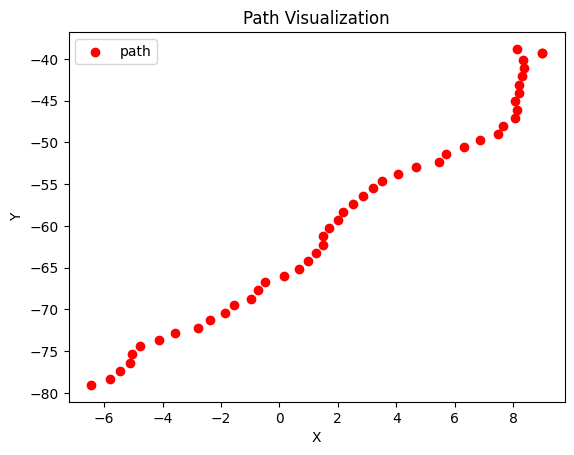

Goal reached! Stopping the vehicle.
Applying Control - Throttle: 0.5, Steering: -0.027821078529710365
Obstacle detected at (-9.426025390625, -81.6139907836914) with distance 3.9278307183774968
Obstacle detected! Stopping and replanning...
Car Location: Location(x=13.091841, y=-13.073657, z=-0.011249)
GPS Data: Lat=0.00011743656821749937, Lon=0.00011760977585704935, Alt=1.9887511730194092
Obstacle detected at (5.342524528503418, -38.34635543823242) with distance 3.771211585934844
Obstacle detected at (20.220155715942383, -14.433525085449219) with distance 2.6018641742057875
Obstacle detected at (20.220155715942383, -14.433525085449219) with distance 2.5221231321831836
Obstacle detected at (20.220155715942383, -14.433525085449219) with distance 2.621676294828084
Obstacle detected at (20.220155715942383, -14.433525085449219) with distance 2.9075850484727455
Obstacle detected at (20.220155715942383, -14.433525085449219) with distance 2.4347088748148473
Obstacle detected at (20.487556457519

Car Location: Location(x=13.091841, y=-13.073657, z=-0.011249)
GPS Data: Lat=0.00011743656821749937, Lon=0.00011760977585704935, Alt=1.9887511730194092
Car Location: Location(x=13.091841, y=-13.073657, z=-0.011249)
GPS Data: Lat=0.00011743656821749937, Lon=0.00011760977585704935, Alt=1.9887511730194092
Car Location: Location(x=13.091841, y=-13.073657, z=-0.011249)
GPS Data: Lat=0.00011743656821749937, Lon=0.00011760977585704935, Alt=1.9887511730194092
Car Location: Location(x=13.091841, y=-13.073657, z=-0.011249)
GPS Data: Lat=0.00011743656821749937, Lon=0.00011760977585704935, Alt=1.9887511730194092
Car Location: Location(x=13.091841, y=-13.073657, z=-0.011249)
GPS Data: Lat=0.00011743656821749937, Lon=0.00011760977585704935, Alt=1.9887511730194092
Car Location: Location(x=13.091841, y=-13.073657, z=-0.011249)
GPS Data: Lat=0.00011743656821749937, Lon=0.00011760977585704935, Alt=1.9887511730194092
Car Location: Location(x=13.091841, y=-13.073657, z=-0.011249)
GPS Data: Lat=0.000117436

In [ ]:
if __name__ == "__main__":
    try:
        start_location = [starting_point.location.x, starting_point.location.y]
        goal_location = [start_location[0] + 15, start_location[1] + 40]
        rrt_star = RRTStar(
            vehicle_length=vehicle_length,
            start=start_location,
            goal=goal_location,
            map_size=[100, 100],
            carla_world=world,
            vehicle=vehicle,
            lidar_sensor=lidar_sensor,
            gps_sensor=gps_sensor
        )
        rrt_star.gps_sensor.listen(lambda data: rrt_star.gps_callback(data))
        rrt_star.lidar_sensor.listen(lambda point_cloud: rrt_star.process_lidar_data(point_cloud))
        rrt_star.plan()
        # rrt_star.prints()
    finally:
        print("Simulation ended.")
        time.sleep(1)
                

In [19]:
vehicle.destroy()
lidar_sensor.destroy()
gps_sensor.destroy()

Car Location: Location(x=13.091841, y=-13.073657, z=-0.011249)
GPS Data: Lat=0.00011743656821749937, Lon=0.00011760977585704935, Alt=1.9887511730194092


False